In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample

In [2]:
# Load datasets
train_df = pd.read_csv('training1.csv')
test_df = pd.read_csv('test.csv')

# Select a subset
train_df = train_df.sample(n=1000, random_state=42)
test_df = test_df.sample(n=500, random_state=42)

# Data Preprocessing
The data preprocessing phase is essential for preparing the dataset for machine learning model training. Initially, the code replaces all occurrences of the value -999 with NaN in both the training and test datasets. This step is crucial for handling missing or erroneous values that are often represented by -999. Next, the SimpleImputer from scikit-learn is used to handle these missing values by imputing them with the mean of the respective columns. The columns EventId, Weight, and Label are excluded from this imputation process as they are not features. After handling missing values, the features are normalized and scaled using the StandardScaler, which standardizes the features by removing the mean and scaling to unit variance. This ensures that the features have a mean of 0 and a standard deviation of 1, which is essential for many machine learning algorithms to perform optimally. Finally, the labels are extracted from the training dataset, converting the categorical labels 's' and 'b' into binary values 1 and 0, respectively. The processed feature matrices X_train and X_test, along with the label vector y_train, are then ready for model training.

In [3]:
# Replace -999 values with NaN
train_df.replace(-999, np.nan, inplace=True)
test_df.replace(-999, np.nan, inplace=True)

# Handle missing values
imputer = SimpleImputer(strategy='mean')
train_df_imputed = imputer.fit_transform(train_df.drop(columns=['EventId', 'Weight', 'Label']))
test_df_imputed = imputer.transform(test_df.drop(columns=['EventId']))

# Normalize and scale features
scaler = StandardScaler()
train_df_scaled = scaler.fit_transform(train_df_imputed)
test_df_scaled = scaler.transform(test_df_imputed)

# Extract labels
X_train = train_df_scaled
y_train = train_df['Label'].apply(lambda x: 1 if x == 's' else 0)
X_test = test_df_scaled

# Model Training
The model training phase involves using grid search to find the optimal hyperparameters for a decision tree classifier. First, a parameter grid is defined, specifying the range of values for various hyperparameters such as criterion (either 'gini' or 'entropy'), max_depth (None or specific values like 10, 20, 30, 40, 50), min_samples_split (2, 10, 20), min_samples_leaf (1, 5, 10), and max_features (None, 'sqrt', 'log2'). The DecisionTreeClassifier is then initialized with a random state for reproducibility.

Next, GridSearchCV is set up with the classifier, the parameter grid, 5-fold cross-validation, accuracy as the scoring metric, and parallel computation using all available CPU cores (n_jobs=-1). The grid search is performed by fitting the model on the training data (X_train, y_train), which exhaustively searches through the specified hyperparameter grid to find the best combination.

After fitting the model, the best estimator is retrieved using grid_search.best_estimator_, and the best hyperparameters are printed. The output indicates that the best parameters found are: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}. This combination of hyperparameters is expected to provide the best performance for the decision tree classifier on the given dataset.

In [4]:
# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize the DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best estimator
best_clf = grid_search.best_estimator_

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}


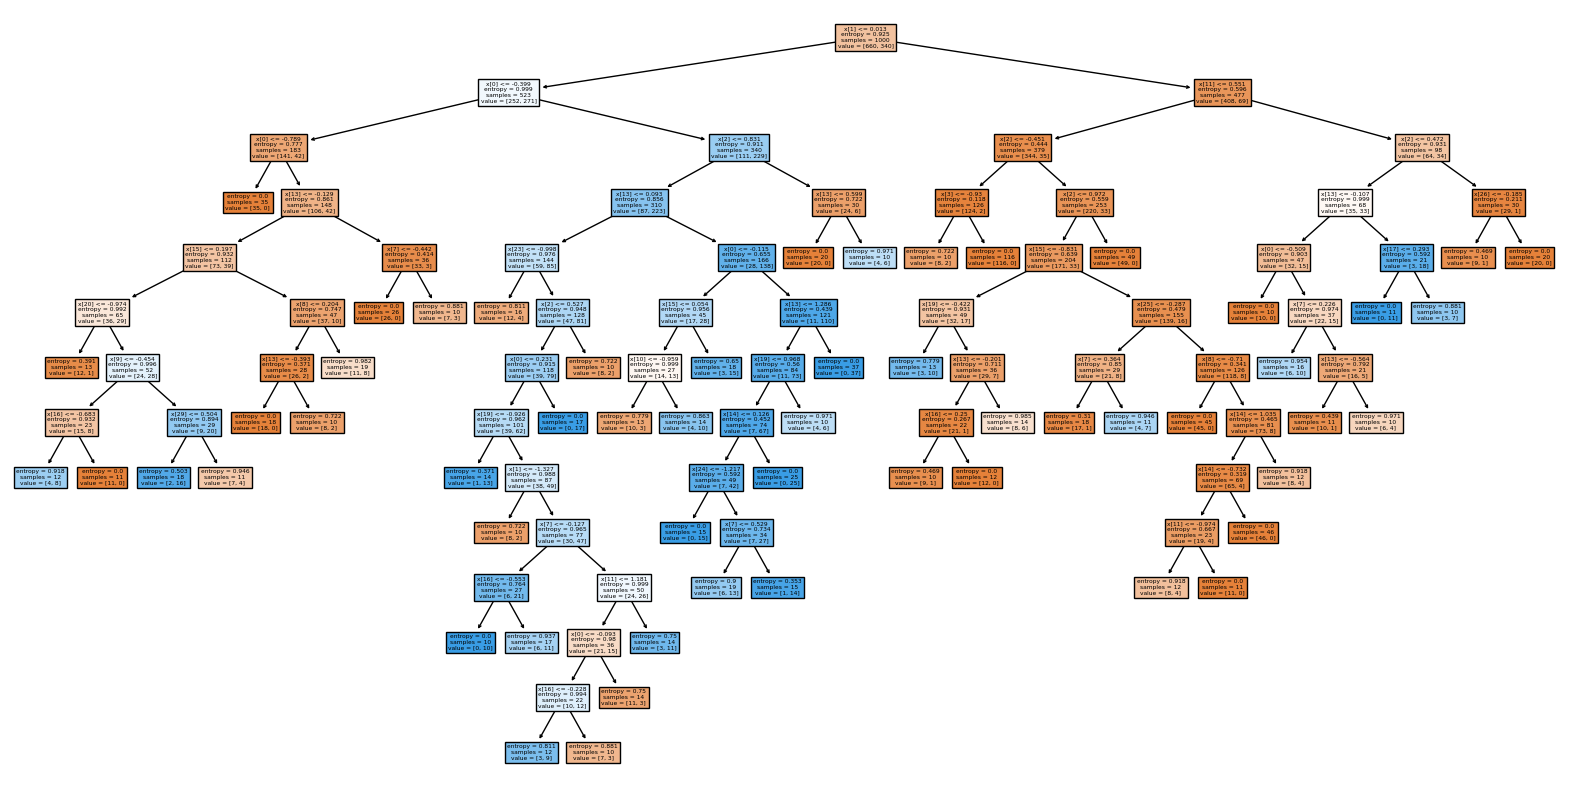

In [5]:
plt.figure(figsize=(20,10))
plt.title("Best Decision Tree")
plot_tree(best_clf, filled=True)
plt.show()

# Cost Complexity Pruning
The cost complexity pruning phase aims to optimize the decision tree by finding the best complexity parameter, alpha (ccp_alpha), to balance model complexity and performance. The process begins by obtaining the cost complexity pruning path using the cost_complexity_pruning_path method, which provides the effective alphas and corresponding total leaf impurities for the subtrees. Variables are initialized to store the best alpha and the highest cross-validated score. For each alpha in the pruning path, a decision tree classifier is trained and evaluated using 5-fold cross-validation. The mean cross-validated score is calculated, and if it exceeds the current best score, the best score and best alpha are updated. This iterative process ensures that the alpha yielding the highest mean cross-validated score is selected as the best alpha. The final decision tree classifier is then trained using this optimal alpha, resulting in a pruned tree that effectively balances complexity and performance. The output indicates that the best alpha found is 0.010356596008538888, with a corresponding cross-validated score of 0.781.

In [6]:
# Get the cost complexity pruning path
path = best_clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Initialize variables to store the best alpha and corresponding score
best_alpha = None
best_score = -np.inf

# Perform cross-validation for each alpha
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    mean_score = np.mean(scores)

    if mean_score > best_score:
        best_score = mean_score
        best_alpha = ccp_alpha

# Train the final model with the best alpha
pruned_clf = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
pruned_clf.fit(X_train, y_train)

# Print the best alpha and corresponding score
print(f"Best alpha found: {best_alpha}")
print(f"Best cross-validated score: {best_score}")

Best alpha found: 0.010356596008538888
Best cross-validated score: 0.781


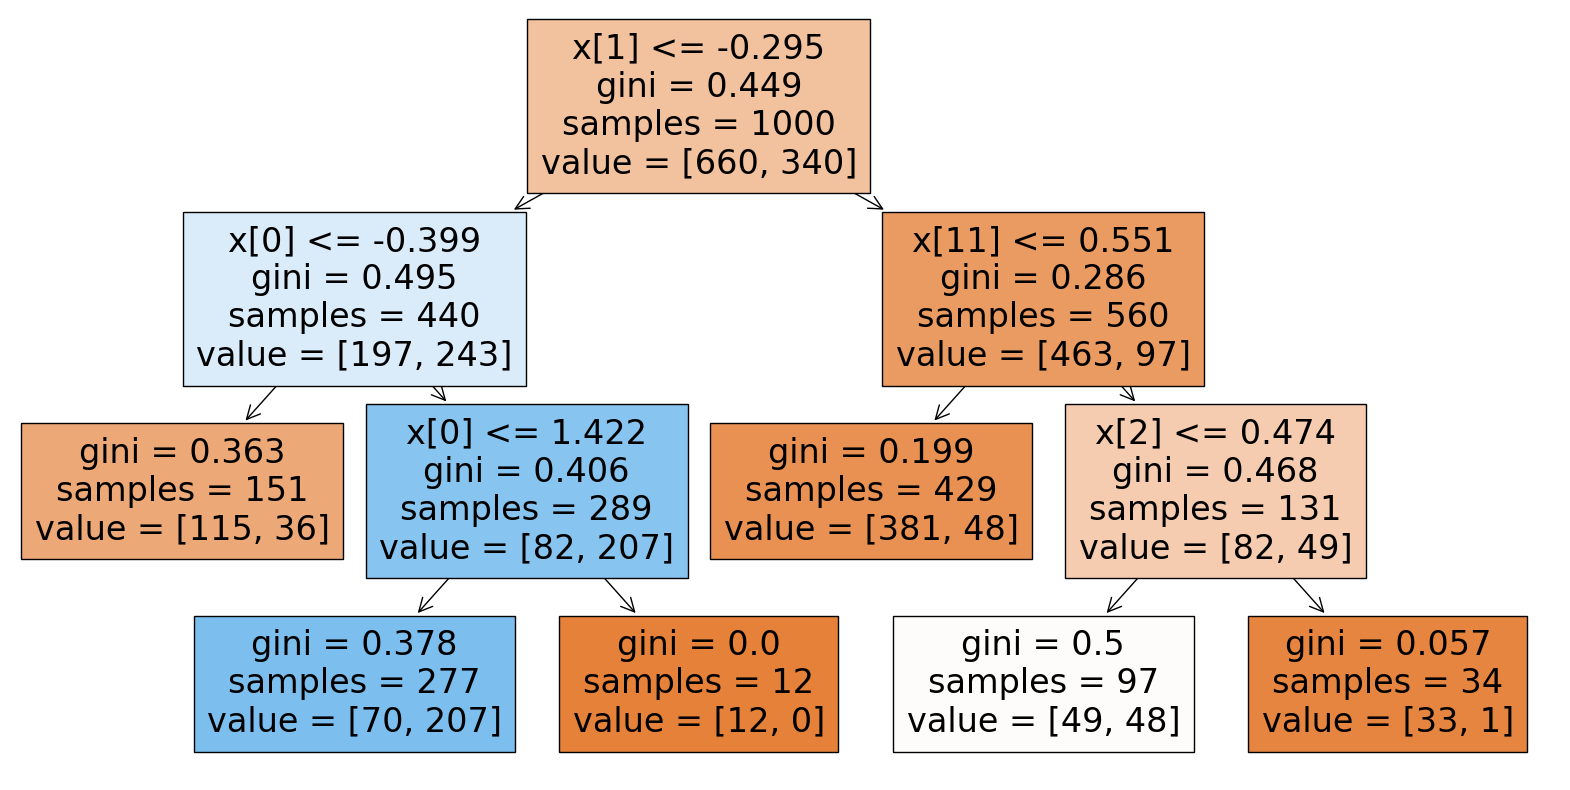

In [7]:
plt.figure(figsize=(20,10))
plt.title("Cost Complexity Pruned Decision Tree")
plot_tree(pruned_clf, filled=True)
plt.show()

# Reduced Error Pruning
The reduced error pruning phase aims to simplify the decision tree by iteratively removing nodes that do not contribute to improving the model's accuracy on a validation set. Initially, the training data is split into a reduced training set and a validation set using train_test_split with an 80-20 split. A decision tree classifier is then trained on the reduced training set. The pruning process involves evaluating each non-leaf node in the tree by temporarily pruning it and checking the resulting accuracy on the validation set. If pruning a node improves or maintains the accuracy, the change is kept; otherwise, the node is restored. This process continues until all nodes have been evaluated. The pruned tree is then evaluated on the validation set, yielding a reduced error pruning score of 0.835.

Compared to cost complexity pruning, which uses a complexity parameter alpha to balance model complexity and performance, reduced error pruning directly evaluates the impact of pruning on a validation set's accuracy. While cost complexity pruning systematically reduces complexity by minimizing a cost function, reduced error pruning is more heuristic, focusing on immediate accuracy improvements. Both methods aim to prevent overfitting, but reduced error pruning is more straightforward and directly tied to validation performance, whereas cost complexity pruning involves a more theoretical approach to balancing tree complexity and performance.

In [8]:
# Split the training data into a new training set and a validation set
X_train_reduced, X_val, y_train_reduced, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train the initial decision tree on the reduced training set
reduced_error_clf = DecisionTreeClassifier(random_state=42)
reduced_error_clf.fit(X_train_reduced, y_train_reduced)

# Function to prune the tree
def prune_tree(tree, X_val, y_val):
    # Get the number of nodes
    n_nodes = tree.tree_.node_count
    # Initialize the best score
    best_score = accuracy_score(y_val, tree.predict(X_val))
    # Initialize the best tree
    best_tree = tree

    # Iterate over all nodes
    for node in range(n_nodes):
        # Check if the node is a leaf node
        if tree.tree_.children_left[node] == tree.tree_.children_right[node]:
            continue

        # Temporarily prune the node
        left_backup = tree.tree_.children_left[node]
        right_backup = tree.tree_.children_right[node]
        tree.tree_.children_left[node] = -1
        tree.tree_.children_right[node] = -1

        # Evaluate the pruned tree
        score = accuracy_score(y_val, tree.predict(X_val))

        # If the pruned tree is better, update the best score and best tree
        if score >= best_score:
            best_score = score
            best_tree = tree
        else:
            # Restore the node if pruning did not improve the score
            tree.tree_.children_left[node] = left_backup
            tree.tree_.children_right[node] = right_backup

    return best_tree

# Prune the tree using the validation set
pruned_reduced_error_clf = prune_tree(reduced_error_clf, X_val, y_val)

# Evaluate the pruned tree
reduced_error_score = accuracy_score(y_val, pruned_reduced_error_clf.predict(X_val))
print(f"Reduced Error Pruning score: {reduced_error_score}")

Reduced Error Pruning score: 0.835


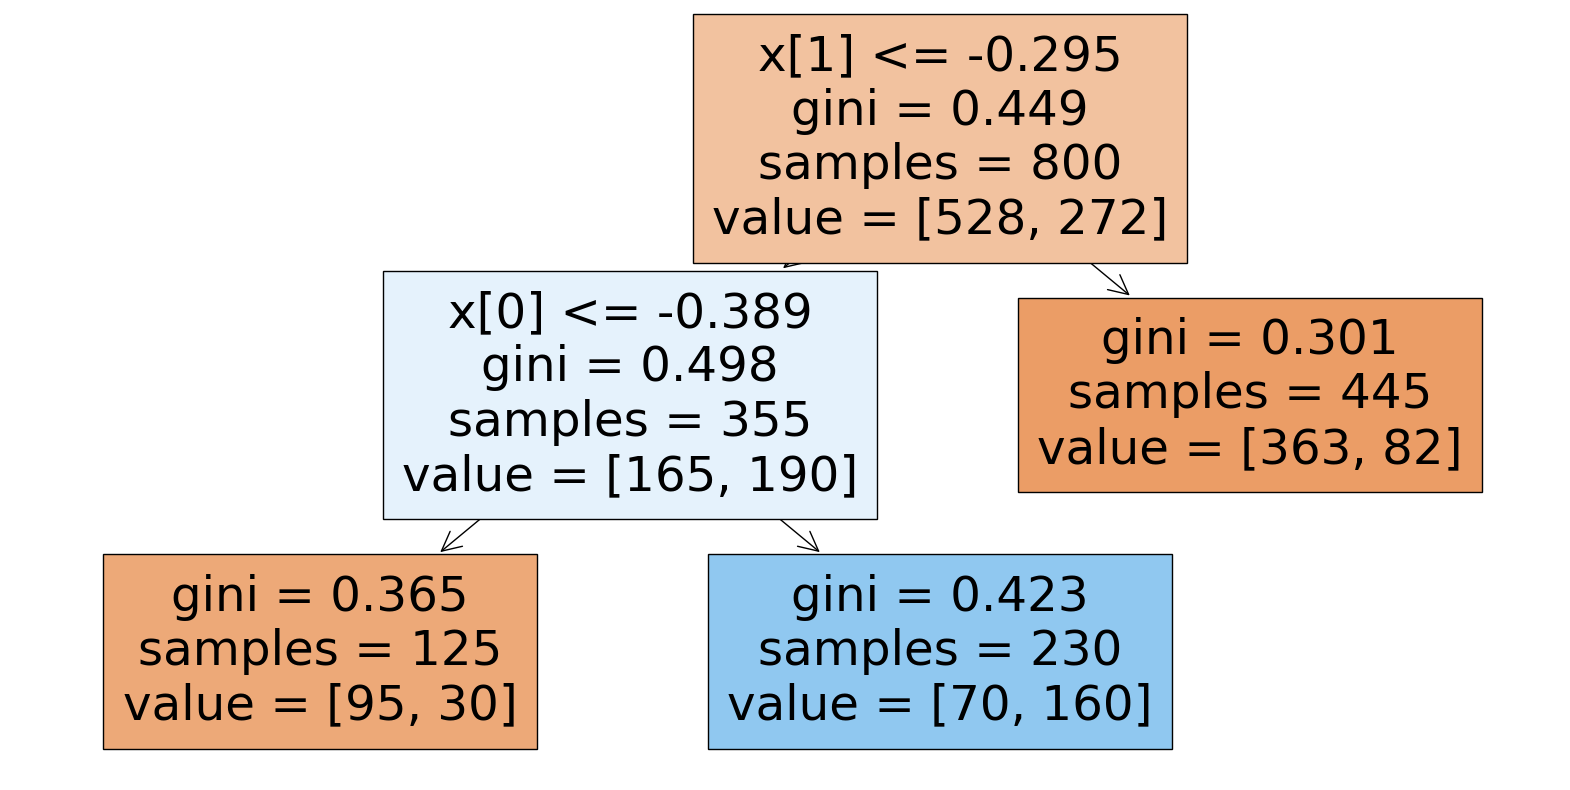

In [9]:
plt.figure(figsize=(20,10))
plt.title("Reduced Error Pruned Decision Tree")
plot_tree(pruned_reduced_error_clf, filled=True)
plt.show()

# Pruning and Validation
The dynamic pruning and validation phase aims to iteratively simplify the decision tree by making pruning decisions based on a separate validation set. Initially, the training data is split into a reduced training set and a validation set using train_test_split with an 80-20 split. A decision tree classifier is then trained on the reduced training set. The dynamic pruning process involves evaluating each non-leaf node in the tree by temporarily pruning it and checking the resulting accuracy on the validation set. If pruning a node improves or maintains the accuracy by at least a specified stopping criteria (0.01 in this case), the change is kept; otherwise, the node is restored. This iterative process continues until all nodes have been evaluated. The pruned tree is then evaluated on the validation set, yielding a dynamic pruning score of 0.835. This method ensures that pruning decisions are directly tied to validation performance, making the model more robust and less prone to overfitting compared to traditional pruning methods like cost complexity pruning.

In [10]:
# Use a separate validation set for dynamic pruning decisions
X_train_pruning, X_val_pruning, y_train_pruning, y_val_pruning = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train the initial decision tree on the training set
dynamic_pruning_clf = DecisionTreeClassifier(random_state=42)
dynamic_pruning_clf.fit(X_train_pruning, y_train_pruning)

# Function to dynamically prune the tree based on validation set
def dynamic_prune_tree(tree, X_val, y_val, stopping_criteria=0.01):
    # Get the number of nodes
    n_nodes = tree.tree_.node_count
    # Initialize the best score
    best_score = accuracy_score(y_val, tree.predict(X_val))
    # Initialize the best tree
    best_tree = tree

    # Iterate over all nodes
    for node in range(n_nodes):
        # Check if the node is a leaf node
        if tree.tree_.children_left[node] == tree.tree_.children_right[node]:
            continue

        # Temporarily prune the node
        left_backup = tree.tree_.children_left[node]
        right_backup = tree.tree_.children_right[node]
        tree.tree_.children_left[node] = -1
        tree.tree_.children_right[node] = -1

        # Evaluate the pruned tree
        score = accuracy_score(y_val, tree.predict(X_val))

        # If the pruned tree is better, update the best score and best tree
        if score >= best_score + stopping_criteria:
            best_score = score
            best_tree = tree
        else:
            # Restore the node if pruning did not improve the score
            tree.tree_.children_left[node] = left_backup
            tree.tree_.children_right[node] = right_backup

    return best_tree

# Dynamically prune the tree using the validation set
pruned_dynamic_clf = dynamic_prune_tree(dynamic_pruning_clf, X_val_pruning, y_val_pruning)

# Evaluate the dynamically pruned tree
dynamic_pruning_score = accuracy_score(y_val_pruning, pruned_dynamic_clf.predict(X_val_pruning))
print(f"Dynamic Pruning score: {dynamic_pruning_score}")

Dynamic Pruning score: 0.835


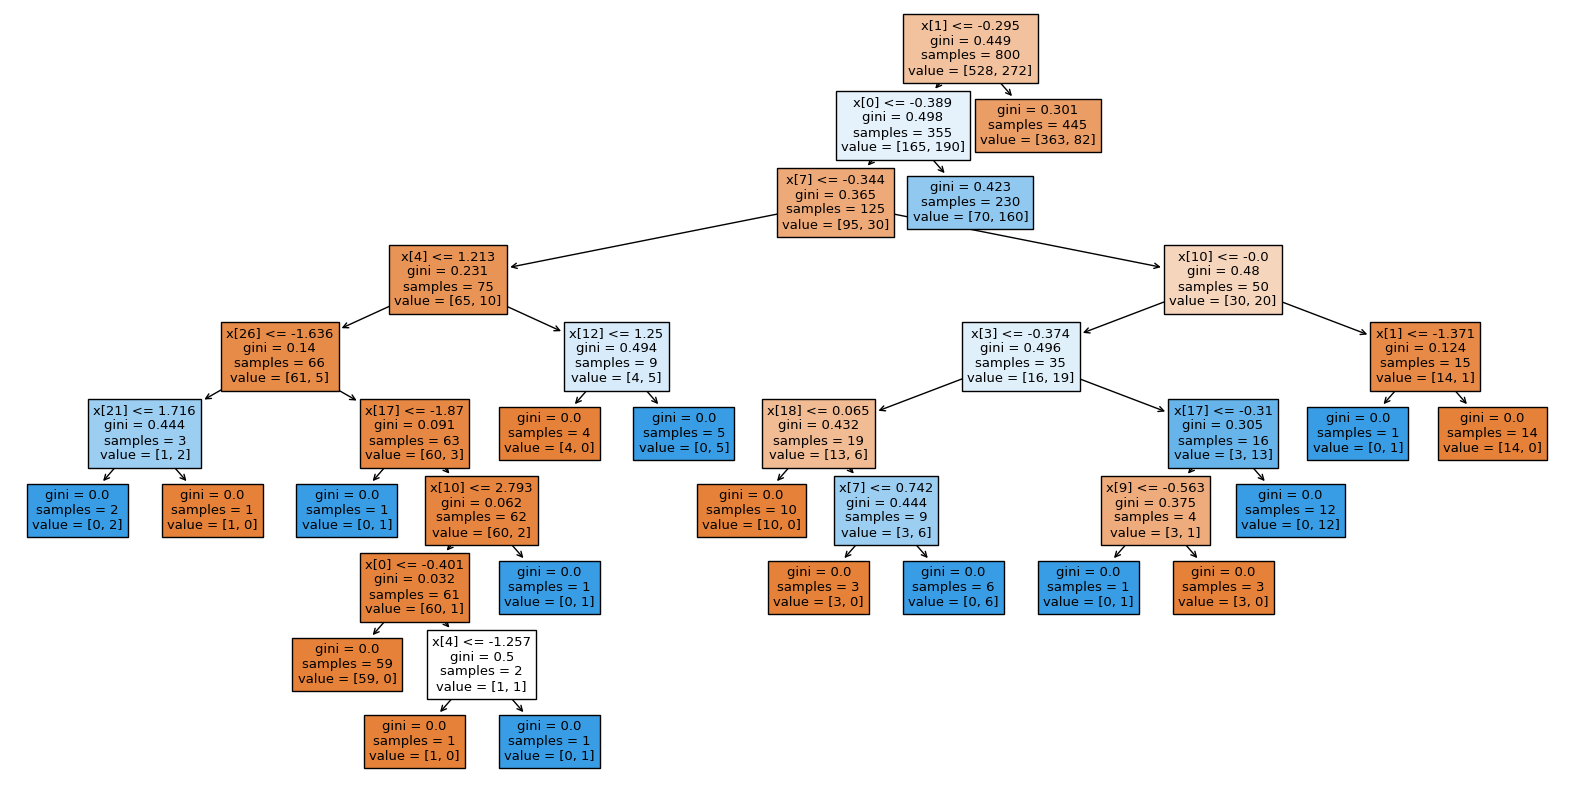

In [11]:
plt.figure(figsize=(20,10))
plt.title("Dynamically Pruned Decision Tree")
plot_tree(pruned_dynamic_clf, filled=True)
plt.show()

# Cross-Validation and Bootstrapping
The cross-validation and bootstrapping phase is designed to rigorously evaluate the performance and stability of the decision tree classifier. Initially, stratified k-fold cross-validation is implemented for hyperparameter tuning and model evaluation. The dataset is split into different numbers of folds (2, 3, and 5), ensuring that each fold maintains the same class distribution as the original dataset. For each fold, the model is trained and evaluated, and the cross-validation scores are recorded. The mean cross-validation scores for 2, 3, and 5 folds are 0.743, 0.780, and 0.746, respectively, indicating the model's performance consistency across different fold splits.

Following cross-validation, the .632 bootstrapping method is employed to further assess the model's performance and stability. This involves generating 100 bootstrap samples, each containing 63.2% of the original training data, with the remaining data used for testing. For each bootstrap iteration, the model is trained on the bootstrap sample and evaluated on the out-of-bag sample. The accuracy, precision, and recall are calculated for each iteration, and the mean and standard deviation of these metrics are computed. The bootstrapped results show a mean accuracy of 0.903 (std 0.015), mean precision of 0.872 (std 0.036), and mean recall of 0.838 (std 0.047).

By comparing the model performance metrics across the different cross-validation methods and bootstrapping, we can evaluate the model's robustness and stability. The cross-validation results indicate that the model performs consistently across different fold splits, while the bootstrapping results provide a robust estimate of the model's performance and its variability. This comprehensive evaluation ensures that the model is both accurate and stable across different subsets of the data, making it reliable for real-world applications.

In [15]:
# Implement stratified k-fold cross-validation for hyperparameter tuning and model evaluation
folds = [2, 3, 5]
cv_results = {}

for fold in folds:
    skf = StratifiedKFold(n_splits=fold)
    cv_scores = cross_val_score(best_clf, X_train, y_train, cv=skf, scoring='accuracy')
    cv_results[fold] = cv_scores
    print(f"Cross-validation scores for {fold} folds: {cv_scores}")
    print(f"Mean cross-validation score for {fold} folds: {np.mean(cv_scores)}")

# .632 Bootstrapping to assess model performance and stability
n_iterations = 100
n_size = int(len(X_train) * 0.632)
bootstrapped_scores = []

for i in range(n_iterations):
    # Prepare train and test sets
    X_train_bootstrap, y_train_bootstrap = resample(X_train, y_train, n_samples=n_size, random_state=i)
    X_test_bootstrap, y_test_bootstrap = resample(X_train, y_train, n_samples=len(X_train) - n_size, random_state=i)

    # Fit the model
    bootstrap_clf = DecisionTreeClassifier(random_state=42, **grid_search.best_params_)
    bootstrap_clf.fit(X_train_bootstrap, y_train_bootstrap)

    # Evaluate the model
    y_pred_bootstrap = bootstrap_clf.predict(X_test_bootstrap)
    accuracy = accuracy_score(y_test_bootstrap, y_pred_bootstrap)
    precision = precision_score(y_test_bootstrap, y_pred_bootstrap)
    recall = recall_score(y_test_bootstrap, y_pred_bootstrap)

    bootstrapped_scores.append((accuracy, precision, recall))

# Calculate mean and standard deviation of bootstrapped scores
bootstrapped_scores = np.array(bootstrapped_scores)
mean_scores = np.mean(bootstrapped_scores, axis=0)
std_scores = np.std(bootstrapped_scores, axis=0)

print(f"Bootstrapped Accuracy: Mean={mean_scores[0]}, Std={std_scores[0]}")
print(f"Bootstrapped Precision: Mean={mean_scores[1]}, Std={std_scores[1]}")
print(f"Bootstrapped Recall: Mean={mean_scores[2]}, Std={std_scores[2]}")


Cross-validation scores for 2 folds: [0.764 0.722]
Mean cross-validation score for 2 folds: 0.743
Cross-validation scores for 3 folds: [0.77245509 0.8018018  0.76576577]
Mean cross-validation score for 3 folds: 0.7800075524626422
Cross-validation scores for 5 folds: [0.725 0.755 0.73  0.72  0.8  ]
Mean cross-validation score for 5 folds: 0.7459999999999999
Bootstrapped Accuracy: Mean=0.9029891304347828, Std=0.014560248178933498
Bootstrapped Precision: Mean=0.8720345814641713, Std=0.035661467260609446
Bootstrapped Recall: Mean=0.8382490705359921, Std=0.04670239162211617
